## Eye diseases

## Import Libraries

In [38]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Class for Loading and Splitting Datasets

In [39]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [40]:
dataDir='dataset/dataset'
print(os.listdir())

['README.md', '.Trash-0', 'SavedModel', 'eye-diseases-classification-Copy1.ipynb', 'dataset', 'Training5-ResNet-Fix.ipynb', 'DatasetPulling.ipynb', 'Training6-EfficientNetB3.ipynb', 'MultiLabel.ipynb', 'eye-diseases-classification.zip', '.gitattributes', 'kaggle.json', '.git', 'ModelComparison.ipynb', 'Training.ipynb', 'augmented_images', '.ipynb_checkpoints', '.gitignore', 'Training2-ResNet.ipynb', 'Training4-ResNet.ipynb']


In [41]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

In [42]:
train_data.info()
valid_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3373 entries, 2771 to 2379
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  3373 non-null   object
 1   labels     3373 non-null   object
dtypes: object(2)
memory usage: 79.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 422 entries, 1641 to 3048
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  422 non-null    object
 1   labels     422 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 422 entries, 1342 to 733
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  422 non-null    object
 1   labels     422 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


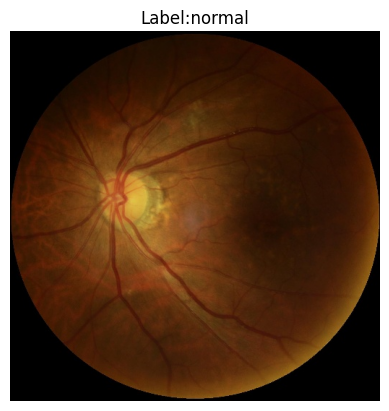

In [43]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']
    
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

In [44]:
train_data['labels'].value_counts()

labels
diabetic_retinopathy    878
normal                  859
cataract                830
glaucoma                806
Name: count, dtype: int64

## Function for Data Augmentation

In [48]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (224,224)
    channels = 3
    color = 'rgb'
    

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])
          
    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
          
    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
   
    print("Shape of augmented training images:", train_generator.image_shape)
          
    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
         
    print("Shape of validation images:", valid_generator.image_shape)
          
    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )
          
    print("Shape of test images:", test_generator.image_shape)
          
    return train_generator, valid_generator, test_generator

In [49]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (224, 224, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (224, 224, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (224, 224, 3)


In [51]:
print(train_augmented.n)
print(valid_augmented.n)
print(test_augmented.n)

3373
422
422


In [53]:
train_augmented.class_indices

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

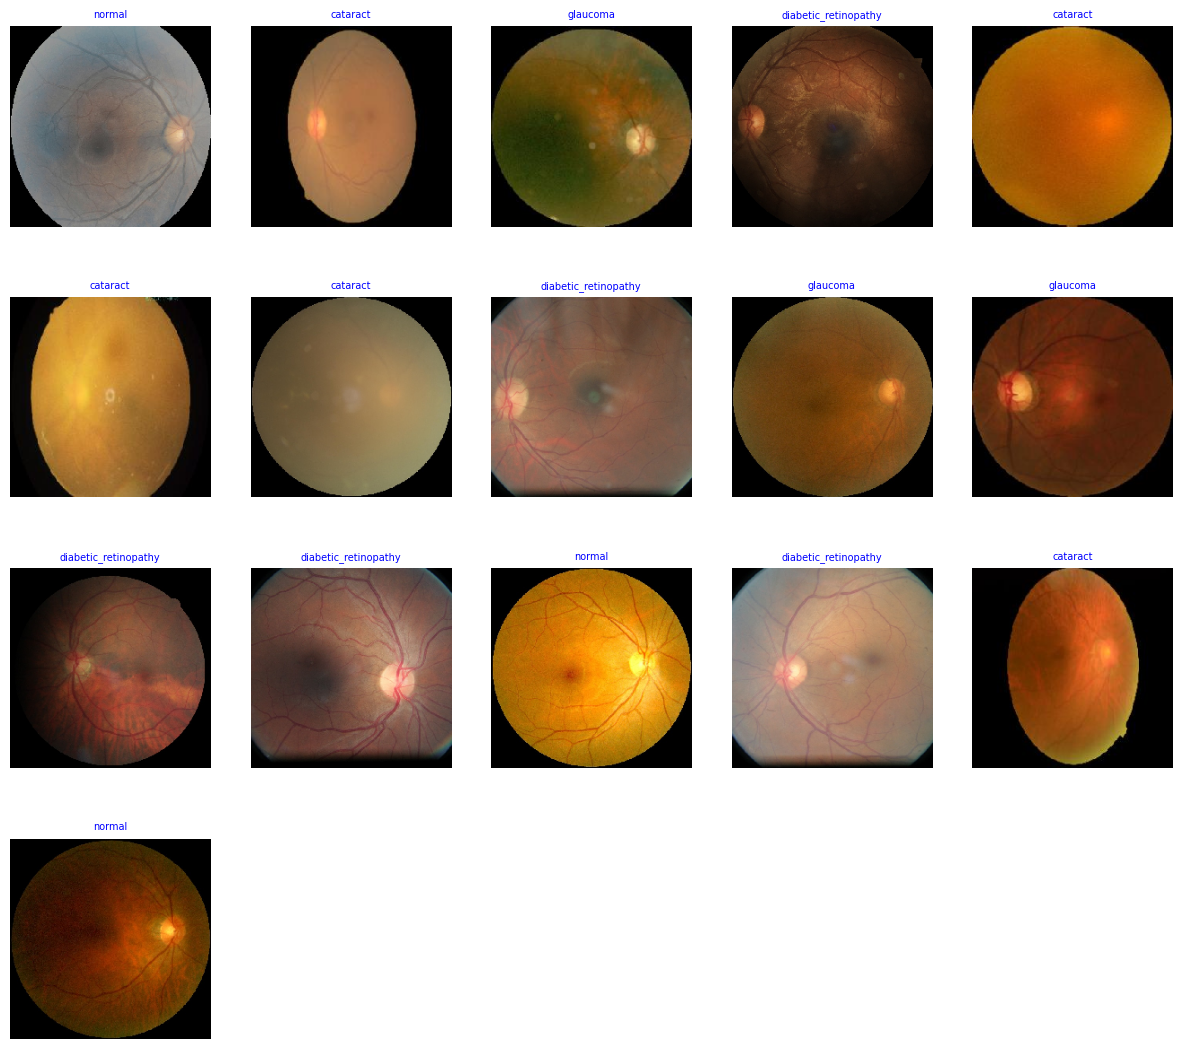

In [80]:
def show_images(gen):    
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)       
    sample = min(length, 20)   
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i]     
        plt.imshow(image/255)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(test_augmented)

## Download and compile the model

In [69]:
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet50.layers[:-10]:
    layer.trainable = False
    
    
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=resnet50.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Fit the model

In [72]:
batch = next(iter(train_augmented))
print("Batch Shapes:", batch[0].shape, batch[1].shape)

Batch Shapes: (16, 224, 224, 3) (16, 4)


In [73]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_augmented,
    epochs=15, 
    validation_data=valid_augmented,
    callbacks=[reduce_lr]
    )

Epoch 1/15
211/211 [==============================] - 49s 215ms/step - loss: 2.7564 - accuracy: 0.7788 - val_loss: 1.3979 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 2/15
211/211 [==============================] - 44s 207ms/step - loss: 0.9572 - accuracy: 0.8550 - val_loss: 0.7330 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 3/15
211/211 [==============================] - 43s 206ms/step - loss: 0.6513 - accuracy: 0.8636 - val_loss: 0.9633 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 4/15
211/211 [==============================] - 45s 212ms/step - loss: 0.5328 - accuracy: 0.8787 - val_loss: 0.4891 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 5/15
211/211 [==============================] - 43s 204ms/step - loss: 0.4602 - accuracy: 0.8900 - val_loss: 0.4465 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 6/15
211/211 [==============================] - 43s 204ms/step - loss: 0.4229 - accuracy: 0.8865 - val_loss: 0.4770 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 7/15
211/211 [==============================] 

In [79]:
model.save('SavedModel/Model5_ResNet-imporve1.h5')

## Plot the Accuracy and Loss

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_images, test_labels = next(iter(test_augmented))
# Model Evaluation
y_pred = (model.predict(test_images) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:")
print(classification_report(test_labels, y_pred))

1/1 [==============================] - 1s 646ms/step
Accuracy: 0.9375
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      0.75      0.86         4
           3       0.80      1.00      0.89         4

   micro avg       0.94      0.94      0.94        16
   macro avg       0.95      0.94      0.94        16
weighted avg       0.95      0.94      0.94        16
 samples avg       0.94      0.94      0.94        16



Training Accuracy: 0.9371479153633118
Validation Accuracy: 0.9123222827911377


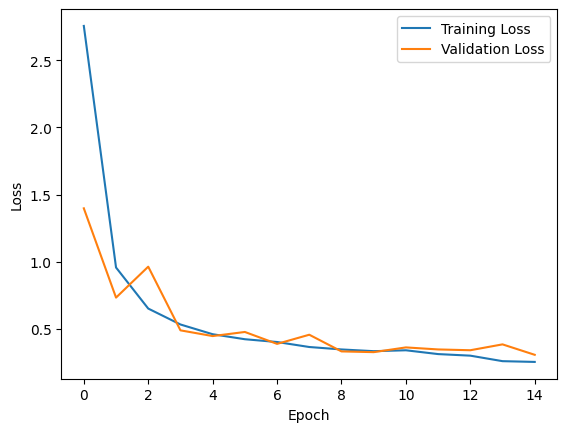

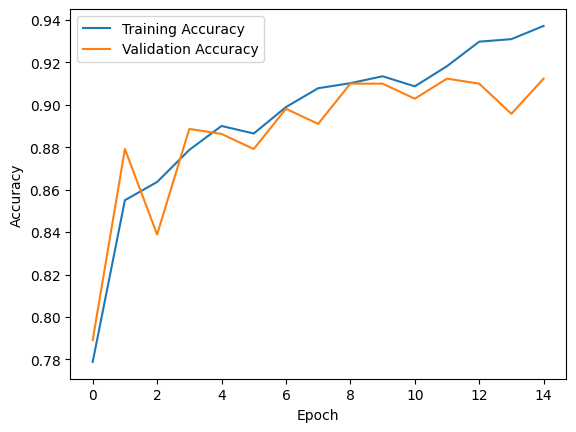

In [76]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

27/27 [==============================] - 2s 61ms/step


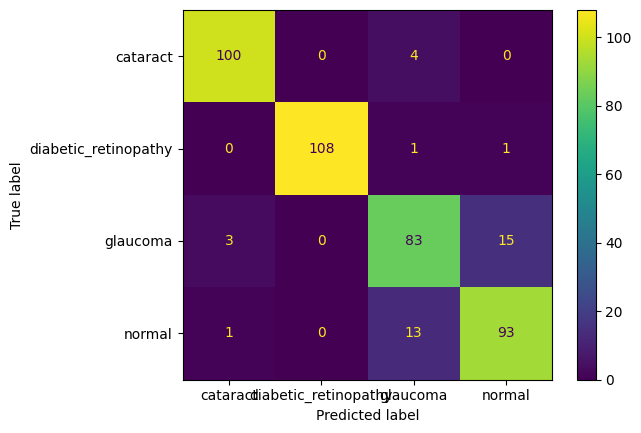

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_augmented.classes
y_pred = model.predict(test_augmented).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_augmented.class_indices)
disp.plot()


## Display the Actual and Predicted images

1/1 [==============================] - 0s 24ms/step


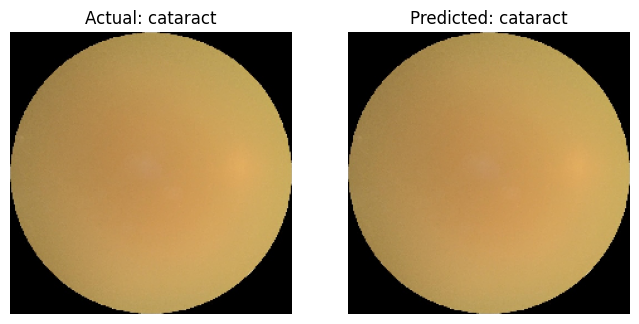

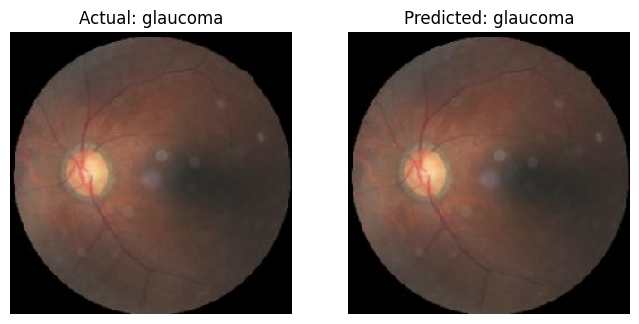

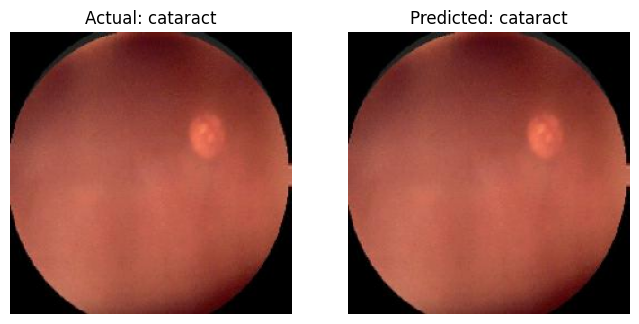

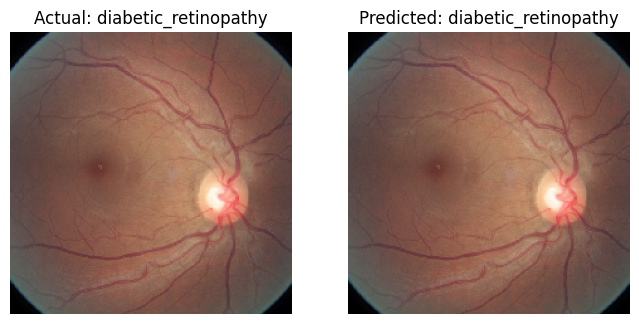

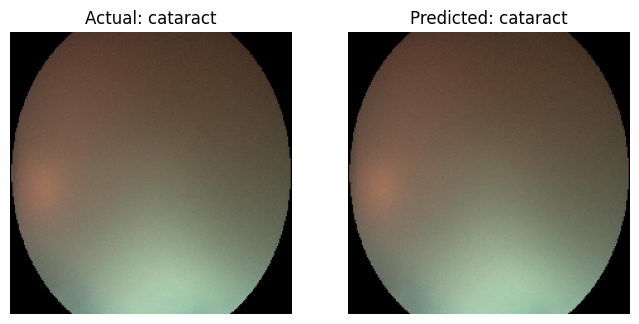

In [82]:
def plot_actual_vs_predicted(model, test_data, num_samples=5):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_augmented))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i]/255)  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i]/255)  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)